In [7]:
import torch
import json
import os
import sys
import types
from argparse import Namespace

### FILL THESE VALUES ###

PATH_TO_REPO         = os.path.expanduser('~/Documents/uzh_tum/models/utae-paps') # '/home/eco03/github/utae-paps/'
PATH_TO_DATA         = os.path.expanduser('~/Data/SEN12MSCRTS_val_test')

experiment_name      = 'utae_S1S2_L1SSIM_europe'
PATH_TO_UTAE_WEIGHTS = os.path.join(os.path.expanduser('~/Documents/uzh_tum/models/utae-paps/results'), experiment_name) # '/home/eco03/DATA/UTAE_zenodo/'
device               = 'cuda' # or "cpu"

#######

import matplotlib.pyplot as plt
from matplotlib.colors import Colormap, ListedColormap
import matplotlib

from matplotlib import patches
import numpy as np

print(os.getcwd())
sys.path.append(PATH_TO_REPO) 
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
print(sys.path)
#sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd()))), 'util','covweighting')

from src.backbones.utae import UTAE
from src.panoptic.paps import PaPs
#from src.dataset import PASTIS_Dataset
#from train_panoptic import recursive_todevice
#from train_reconstruct import recursive_todevice#, prepare_data
from src.utils import pad_collate
from src.model_utils import get_model
from data.dataLoader import SEN12MSCRTS

from captum.attr import IntegratedGradients
from sklearn.linear_model import LinearRegression

import cv2 as cv

import warnings
warnings.filterwarnings('ignore')


# Colormap (same as in the paper)
cm = matplotlib.cm.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,19)]+['w']
cmap = ListedColormap(colors = cus_colors, name='agri',N=20)

from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
redgreen = LinearSegmentedColormap.from_list('shap', colors)

label_names = [
'Background',
'Meadow',
'Soft winter wheat',
'Corn',
'Winter barley',
'Winter rapeseed',
'Spring barley',
'Sunflower',
'Grapevine',
'Beet',
 'Winter triticale',
 'Winter durum wheat',
 'Fruits,  vegetables, flowers',
 'Potatoes',
 'Leguminous fodder',
 'Soybeans',
 'Orchard',
 'Mixed cereal',
 'Sorghum',
 'Void label']


/home/eco04/Documents/uzh_tum/util/interpret
['/home/eco04/Documents/uzh_tum/util/interpret', '/usr/lib/python39.zip', '/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '', '/home/eco04/.local/lib/python3.9/site-packages', '/usr/local/lib/python3.9/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.9/dist-packages', '/home/eco04/Documents/uzh_tum/models/utae-paps', '/home/eco04/Documents/uzh_tum/util', '/home/eco04/Documents/uzh_tum', '/home/eco04/Documents/uzh_tum/util', '/home/eco04/Documents/uzh_tum', '/home/eco04/Documents/uzh_tum', '/home/eco04/Documents/uzh_tum/util/covweighting', '/home/eco04/Documents/uzh_tum', '/home/eco04/Documents/uzh_tum', '/home/eco04/Documents/uzh_tum/models/utae-paps', '/home/eco04/Documents/uzh_tum/util', '/home/eco04/Documents/uzh_tum', '/home/eco04/Documents/uzh_tum', '/home/eco04/Documents/uzh_tum/util/covweighting', '/home/eco04/Documents/uzh_tum/models/utae-paps', '/home/eco04/Documents/uzh_tum/util', '/home/eco04/Documents/u

Detected 11 keypoints.


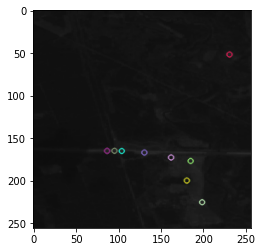

In [8]:
img = cv.imread(os.path.expanduser('~/Documents/uzh_tum/models/utae-paps/results/utae_SSIM/plots/epoch_185/train/img-2_target_t-0.png'))
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
# initiate a SIFT instance, see https://docs.opencv.org/3.4/d7/d60/classcv_1_1SIFT.html
sift = cv.SIFT_create(nfeatures=10, contrastThreshold=0.01,edgeThreshold=10) # only keep top-10 keypoints, sorted by local contrast score 
kp = sift.detect(gray,None) # TODO: You can pass a mask if you want to search only a part of image.
print(f'Detected {len(kp)} keypoints.')
img=cv.drawKeypoints(gray,kp,img)
cv.imwrite(os.path.expanduser('~/Documents/sift_keypoints.jpg'),img)
imgplot = plt.imshow(img)
plt.show()

In [9]:
def recursive_todevice(x, device):
    if isinstance(x, torch.Tensor):
        return x.to(device)
    elif isinstance(x, dict):
        return {k: recursive_todevice(v, device) for k, v in x.items()}
    else:
        return [recursive_todevice(c, device) for c in x]

def prepare_data(batch, device, config):
    in_S2 = recursive_todevice(batch['input']['S2'], device)
    in_S2_td = recursive_todevice(batch['input']['S2 TD'], device)
    if config.batch_size>1: in_S2_td = torch.stack((in_S2_td)).T
    in_m  = torch.stack(recursive_todevice(batch['input']['masks'], device)).swapaxes(0,1)
    #target_S1 = recursive_todevice(batch['target']['S1'], device)
    target_S2 = recursive_todevice(batch['target']['S2'], device)
    #target_S1_td = recursive_todevice(batch['target']['S1 TD'], device)
    #target_S2_td = recursive_todevice(batch['target']['S2 TD'], device)
    #target_m  = recursive_todevice(batch['target']['masks'], device)
    y     = torch.cat(target_S2,dim=0).unsqueeze(1)

    if config.use_sar: 
        in_S1 = recursive_todevice(batch['input']['S1'], device)
        in_S1_td = recursive_todevice(batch['input']['S1 TD'], device)
        if config.batch_size>1: in_S1_td = torch.stack((in_S1_td)).T
        x     = torch.cat((torch.stack(in_S1,dim=1), torch.stack(in_S2,dim=1)),dim=2)
        dates = torch.stack((torch.tensor(in_S1_td),torch.tensor(in_S2_td))).float().mean(dim=0).to(device)
    else:
        x     = torch.stack(in_S2,dim=1)
        dates = torch.tensor(in_S2_td).float().to(device)

    if config.input_size < 256: # batch sub-samples if mosaicing patches
        x_mosaic = x.unfold(4, config.input_size, config.input_size).unfold(3, config.input_size, config.input_size)
        x_batch  = x_mosaic.reshape(-1, config.input_t, x.shape[2], config.input_size, config.input_size).swapaxes(-1,-2)
        y_mosaic = y.unfold(4, config.input_size, config.input_size).unfold(3, config.input_size, config.input_size)
        y_batch  = y_mosaic.reshape(-1, 1, y.shape[2], config.input_size, config.input_size).swapaxes(-1,-2)
        m_mosaic = in_m.unfold(3, config.input_size, config.input_size).unfold(2, config.input_size, config.input_size)
        m_batch  = m_mosaic.reshape(-1, config.input_t, config.input_size, config.input_size).swapaxes(-1,-2)

        x, y, in_m, dates = x_batch, y_batch, m_batch, dates.expand(x_batch.shape[0],-1)
    return x, y, in_m, dates

In [10]:
def load_model(path, device, fold=0, mode='reconstruct', add_args=None):
    """Load pre-trained model"""
    with open(os.path.join(path, 'conf.json')) as file:
        config = json.loads(file.read())
        
    if add_args is not None:
        config = {**config, **add_args}
    config = Namespace(**config)
    model = get_model(config, mode = mode).to(device)

    sd = torch.load(
        #os.path.join(path, "Fold_{}".format(fold+1), "model.pth.tar"),
        os.path.join(path, "model.pth.tar"),
        map_location=device
        )
    model.load_state_dict(sd['state_dict'])
    
    
    return model

def get_rgb(x,b=0,t_show=6):
    """Gets an observation from a time series and normalises it for visualisation."""
    im = x[b,t_show,[2,1,0]].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

In [11]:
# Load dataset and models

fold = 0
batch_size = 1
root1 = '/media/DATA/SEN12MSCRTS'
root2 = '~/Data/SEN12MSCRTS_val_test'
region = "europa"
sample_type = "cloudy_cloudfree"
input_t = 3
use_sar = True
patch_size = 256
#dt = PASTIS_Dataset(folder=PATH_TO_DATA, norm=True, target='instance', folds=[fold],)
#dl = torch.utils.data.DataLoader(dt, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)

dt_train    = SEN12MSCRTS(os.path.expanduser(root1), split='train', region=region, sample_type=sample_type , n_input_samples=input_t, import_data_path=None)
dt_val      = SEN12MSCRTS(os.path.expanduser(root2), split='val', region=region, sample_type=sample_type , n_input_samples=input_t, import_data_path=None) 
dt_test     = SEN12MSCRTS(os.path.expanduser(root2), split='test', region=region, sample_type=sample_type , n_input_samples=input_t, import_data_path=None)

dl = torch.utils.data.DataLoader(
    dt_test,
    batch_size=batch_size,
    shuffle=False,
    #num_workers=num_workers,
    #drop_last=True,
    #collate_fn=collate_fn,
)

iterator =  dl.__iter__()
device = torch.device(device)


utae = load_model(PATH_TO_UTAE_WEIGHTS, device=device, fold=fold, mode='reconstruct', add_args=dict(positional_encoding=False)).eval()


Processing paths for train split of region europa


100%|█████| 17/17 [00:03<00:00,  5.12it/s]



Processing paths for val split of region europa


100%|██| 17/17 [00:00<00:00, 29946.73it/s]



Processing paths for test split of region europa


100%|█████| 17/17 [00:01<00:00, 15.05it/s]


In [14]:
#batch = recursive_todevice(iterator.__next__(), device)
#(x, dates), y = batch

batch  = iterator.__next__()
config = types.SimpleNamespace()
for adx, attr in enumerate(['batch_size', 'use_sar', 'input_size']):
    setattr(config, attr, [batch_size, use_sar, patch_size][adx])
x, y, in_m, dates = prepare_data(batch, device, config)

In [16]:
ig = IntegratedGradients(utae.eval())

## Baseline: 
#B,T,C,H,W = x.shape
#baselines = dt.norm['S2'][0].unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)
#baselines = baselines.repeat((B,T,1,H,W))
baselines = torch.zeros(x.shape,device=device)
print(y.shape)

torch.Size([1, 1, 13, 256, 256])


In [ ]:
ig = IntegratedGradients(utae.eval())

## Baseline: 
#B,T,C,H,W = x.shape
#baselines = dt.norm['S2'][0].unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)
#baselines = baselines.repeat((B,T,1,H,W))
baselines = torch.zeros(x.shape,device=device)

target = y[:,:,:,-1] # TODO
n      = 1           # batch sample to analyze
t      = input_t     # time points to consider, with [0, ..., t]
h,w    = 32, 32      # position of px to be explained



pixel_i = 15
pixel_j = 20
pixel_class = target[0, pixel_i, pixel_j].long()

torch.cuda.empty_cache()
attributions = ig.attribute(inputs=x[:n,:t,:,:h,:h], 
                            baselines=baselines[:n,:t,:,:h,:h], 
                            target=(pixel_class, pixel_i, pixel_j), 
                            additional_forward_args=dates[:n,:t])

In [ ]:
with torch.no_grad():
    sempred , attention = utae(x[:1,:t], batch_positions=dates[:1,:t], return_att=True)
    
sempred = sempred.argmax(dim=1)[0].cpu()
at = attributions[0].sum(dim=1).cpu()
at_max = at.max()
at_min = at.min()


cum_attention = attention[:,0,:, pixel_i//8, pixel_j//8].sum(0)

matplotlib.rcParams.update({'font.size': 18})

gt = y[0,:,:,-1].cpu()
clas = gt[pixel_i, pixel_j]

fig, axes = plt.subplots((t//5) + 1,5, figsize=(20,20))
axes = axes.ravel()

for i in range(t):
    axes[i].imshow(get_rgb(x, b=0, t_show=i)[:h,:h], alpha=.5)
    t_plot = at[i]
    #t_plot[abs(t_plot)<0.01] = np.nan
    
    axes[i].imshow(t_plot, cmap=redgreen, alpha=.7, vmin=at_min, vmax=at_max)
    axes[i].set_xlabel(f'date {i+1}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].text(32,5, 'Att: {:.2f}'.format(cum_attention[i]))


    
axes[-1].matshow(y[0,:h,:h,-1].cpu(), cmap=cmap, vmin=0, vmax=19)
axes[-1].set_xlabel('Ground Truth / Red Point : interpreted prediction')
axes[-2].set_xlabel('Semantic Segmentation')


axes[-2].matshow(sempred[:h,:h], cmap=cmap, vmin=0, vmax=19)
axes[-1].scatter(pixel_j, pixel_i,marker='o',color='r')
axes[-2].scatter(pixel_j, pixel_i,marker='o',color='r')


plt.show()


fig, ax = plt.subplots()
ca = cum_attention.cpu().numpy()
exp = at.abs().sum((1,2)).cpu().numpy()
ax.scatter(cum_attention.cpu(),at.abs().sum((1,2)).cpu())
ax.set_xlabel('Attention')
ax.set_ylabel('Integrated Gradient (abs)')

lr = LinearRegression()
lr.fit(ca.reshape(-1, 1), exp.reshape(-1, 1))
line = (lr.intercept_ + lr.coef_ * ca).reshape(-1)

#m = torch.cat([cum_attention.cpu(), at.sum((1,2)).abs()]).max().cpu()
ax.plot(ca, line, color='g', linestyle='--')

plt.show()



### Spatio-temporal explanation visualisation

In [ ]:
attributions.shape

In [ ]:
B,T,C,H,W = attributions.shape

distance_mask = np.zeros((H,W), dtype=int)
for i in range(H):
    for j in range(W):
        distance_mask[i,j] = int(abs(i - pixel_i) + abs(j - pixel_j))
        
distances = np.unique(distance_mask)

In [ ]:
a = attributions[0].sum(1) #TxHxW
stat = []


for d in distances:
    mask = distance_mask==d
    values = a[:,mask]
    stat.append(values.sum(-1))

stat = torch.stack(stat)

fig, ax = plt.subplots(figsize=(5,10))
plt.colorbar(ax.imshow(stat.cpu()))
ax.set_ylabel('Distance to explained pixel')
ax.set_xlabel('Time')
plt.show()